# Install dependences

In [1]:
!pip install mne pandas numpy matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline

In [3]:
%cd /content/drive/MyDrive/physionet.org/files/eegmat/1.0.0

/content/drive/MyDrive/physionet.org/files/eegmat/1.0.0


#Load Data

In [4]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

def load_eeg_data(path):
  eeg = mne.io.read_raw_edf(path,preload=True, verbose=False)
  return eeg

In [5]:
rest_subjects=glob('Subject*_1.edf')
task_subjects=glob('Subject*_2.edf')
rest_subjects.sort()
task_subjects.sort()

In [ ]:
rest_subjects

['Subject00_1.edf',
 'Subject01_1.edf',
 'Subject02_1.edf',
 'Subject03_1.edf',
 'Subject04_1.edf',
 'Subject05_1.edf',
 'Subject06_1.edf',
 'Subject07_1.edf',
 'Subject08_1.edf',
 'Subject09_1.edf',
 'Subject10_1.edf',
 'Subject11_1.edf',
 'Subject12_1.edf',
 'Subject13_1.edf',
 'Subject14_1.edf',
 'Subject15_1.edf',
 'Subject16_1.edf',
 'Subject17_1.edf',
 'Subject18_1.edf',
 'Subject19_1.edf',
 'Subject20_1.edf',
 'Subject21_1.edf',
 'Subject22_1.edf',
 'Subject23_1.edf',
 'Subject24_1.edf',
 'Subject25_1.edf',
 'Subject26_1.edf',
 'Subject27_1.edf',
 'Subject28_1.edf',
 'Subject29_1.edf',
 'Subject30_1.edf',
 'Subject31_1.edf',
 'Subject32_1.edf',
 'Subject33_1.edf',
 'Subject34_1.edf',
 'Subject35_1.edf']

In [ ]:
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
        'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
        'Gamma (30-100)': (30, 100)}

In [ ]:
eeg_rest = load_eeg_data(rest_subjects[0])
eeg_task = load_eeg_data(task_subjects[0])

Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/eegmat/1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


#Compute PSD

In [ ]:
def calculate_psd(eeg, fmin=0, fmax=100, average=True, bands=None):
  if bands==None:
    psd = eeg.compute_psd(fmin=fmin, fmax=fmax, verbose=False).get_data(return_freqs=True)
    return np.mean(psd[0],axis=0), psd[1] if average else psd[0], psd[1]
  else:
    psd = {}
    for band in bands:
      psd_value = eeg.compute_psd(fmin=bands[band][0], fmax=bands[band][1], verbose=False).get_data(return_freqs=True)
      psd[band] = np.mean(psd_value[0],axis=0), psd_value[1] if average else psd_value[0], psd_value[1]
    return psd

In [ ]:
psd_rest = calculate_psd(eeg_rest)
psd_task = calculate_psd(eeg_task)

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


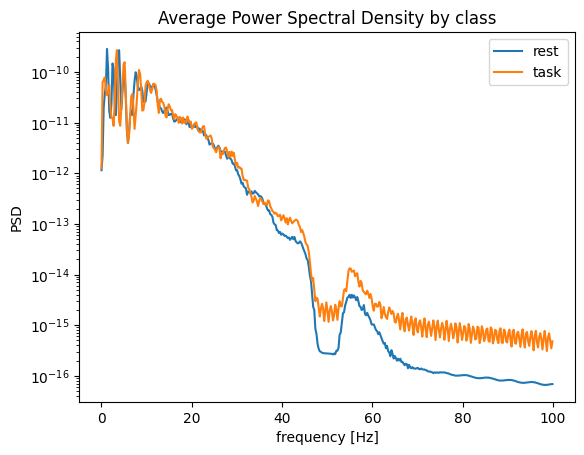

In [ ]:
plt.semilogy(psd_rest[1], psd_rest[0], label='rest')
plt.semilogy(psd_task[1], psd_task[0], label='task')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title("Average Power Spectral Density by class")
plt.legend()
plt.show()

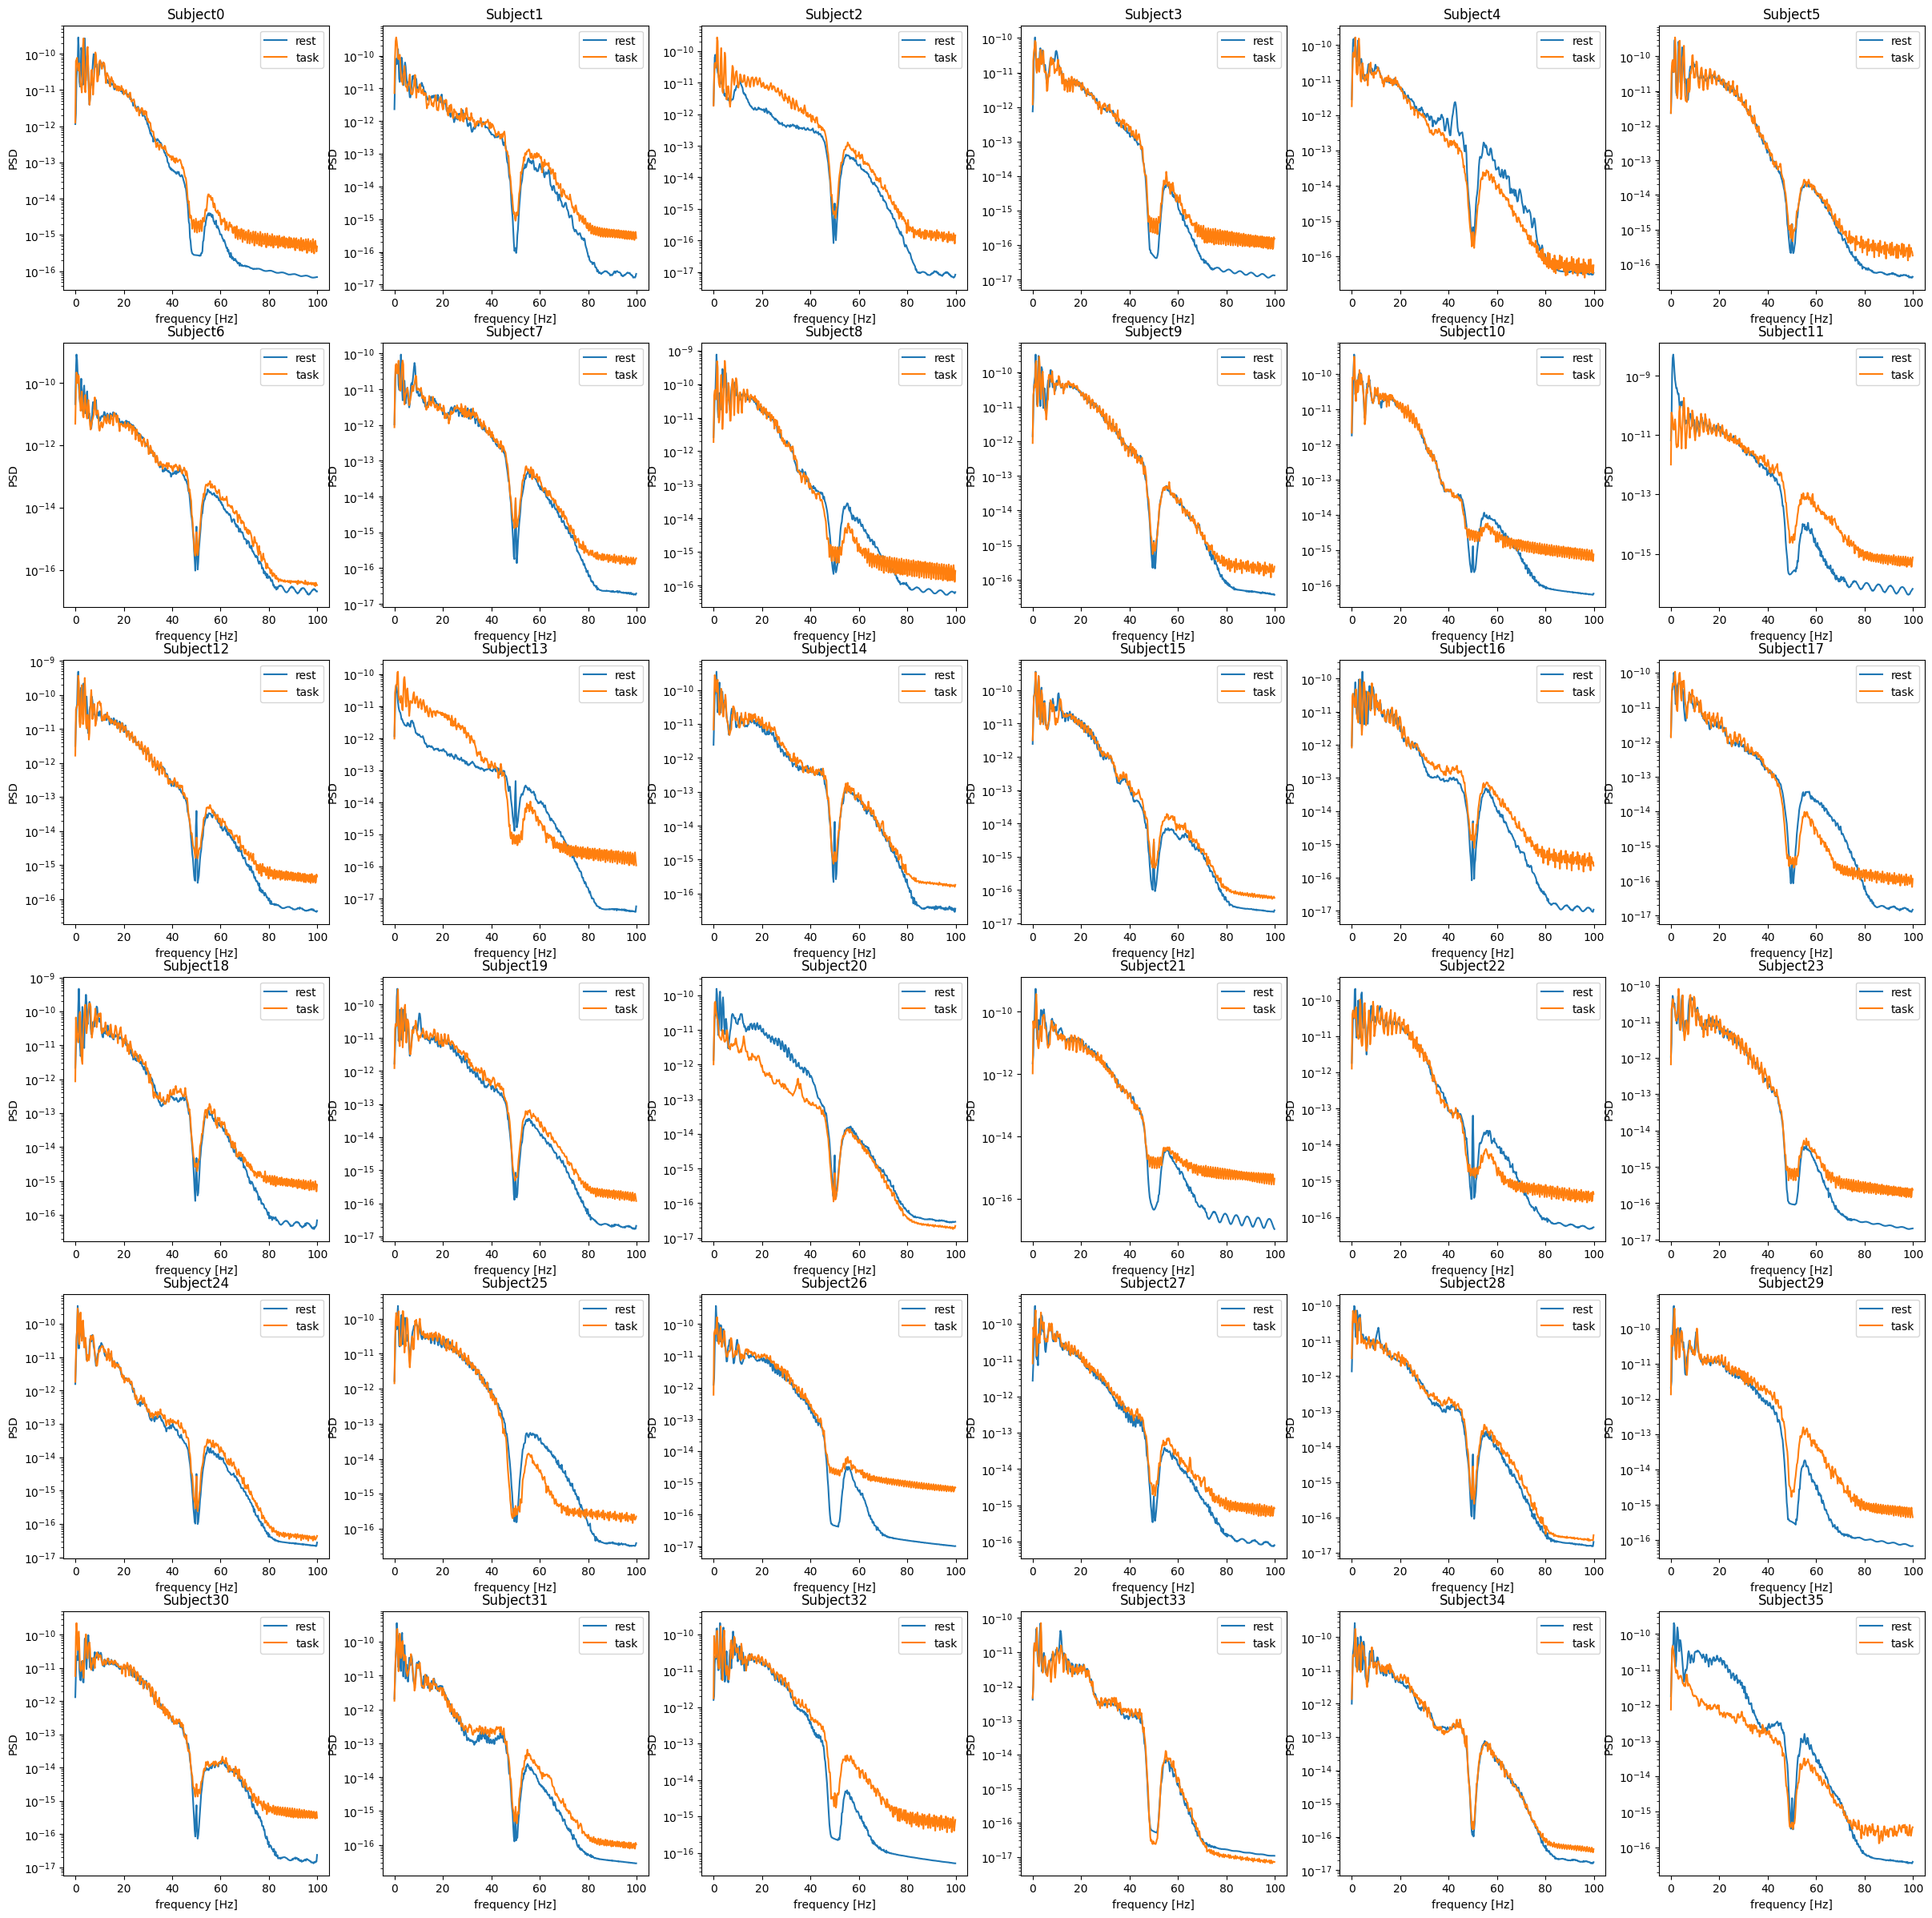

In [ ]:
subject_id=0
fig,axs= plt.subplots(6,6)
fig.set_size_inches(30,30)
for x in range(0,6):
  for y in range(0,6):
    eeg_rest = load_eeg_data(rest_subjects[subject_id])
    eeg_task = load_eeg_data(task_subjects[subject_id])
    psd_rest = calculate_psd(eeg_rest)
    psd_task = calculate_psd(eeg_task)
    axs[x,y].semilogy(psd_rest[1], psd_rest[0], label='rest')
    axs[x,y].semilogy(psd_task[1], psd_task[0], label='task')
    axs[x,y].set_xlabel('frequency [Hz]')
    axs[x,y].set_ylabel('PSD')
    axs[x,y].set_title(f"Subject{subject_id}")
    axs[x,y].legend()
    subject_id+=1
plt.show()

In [ ]:
len(rest_subjects)

36

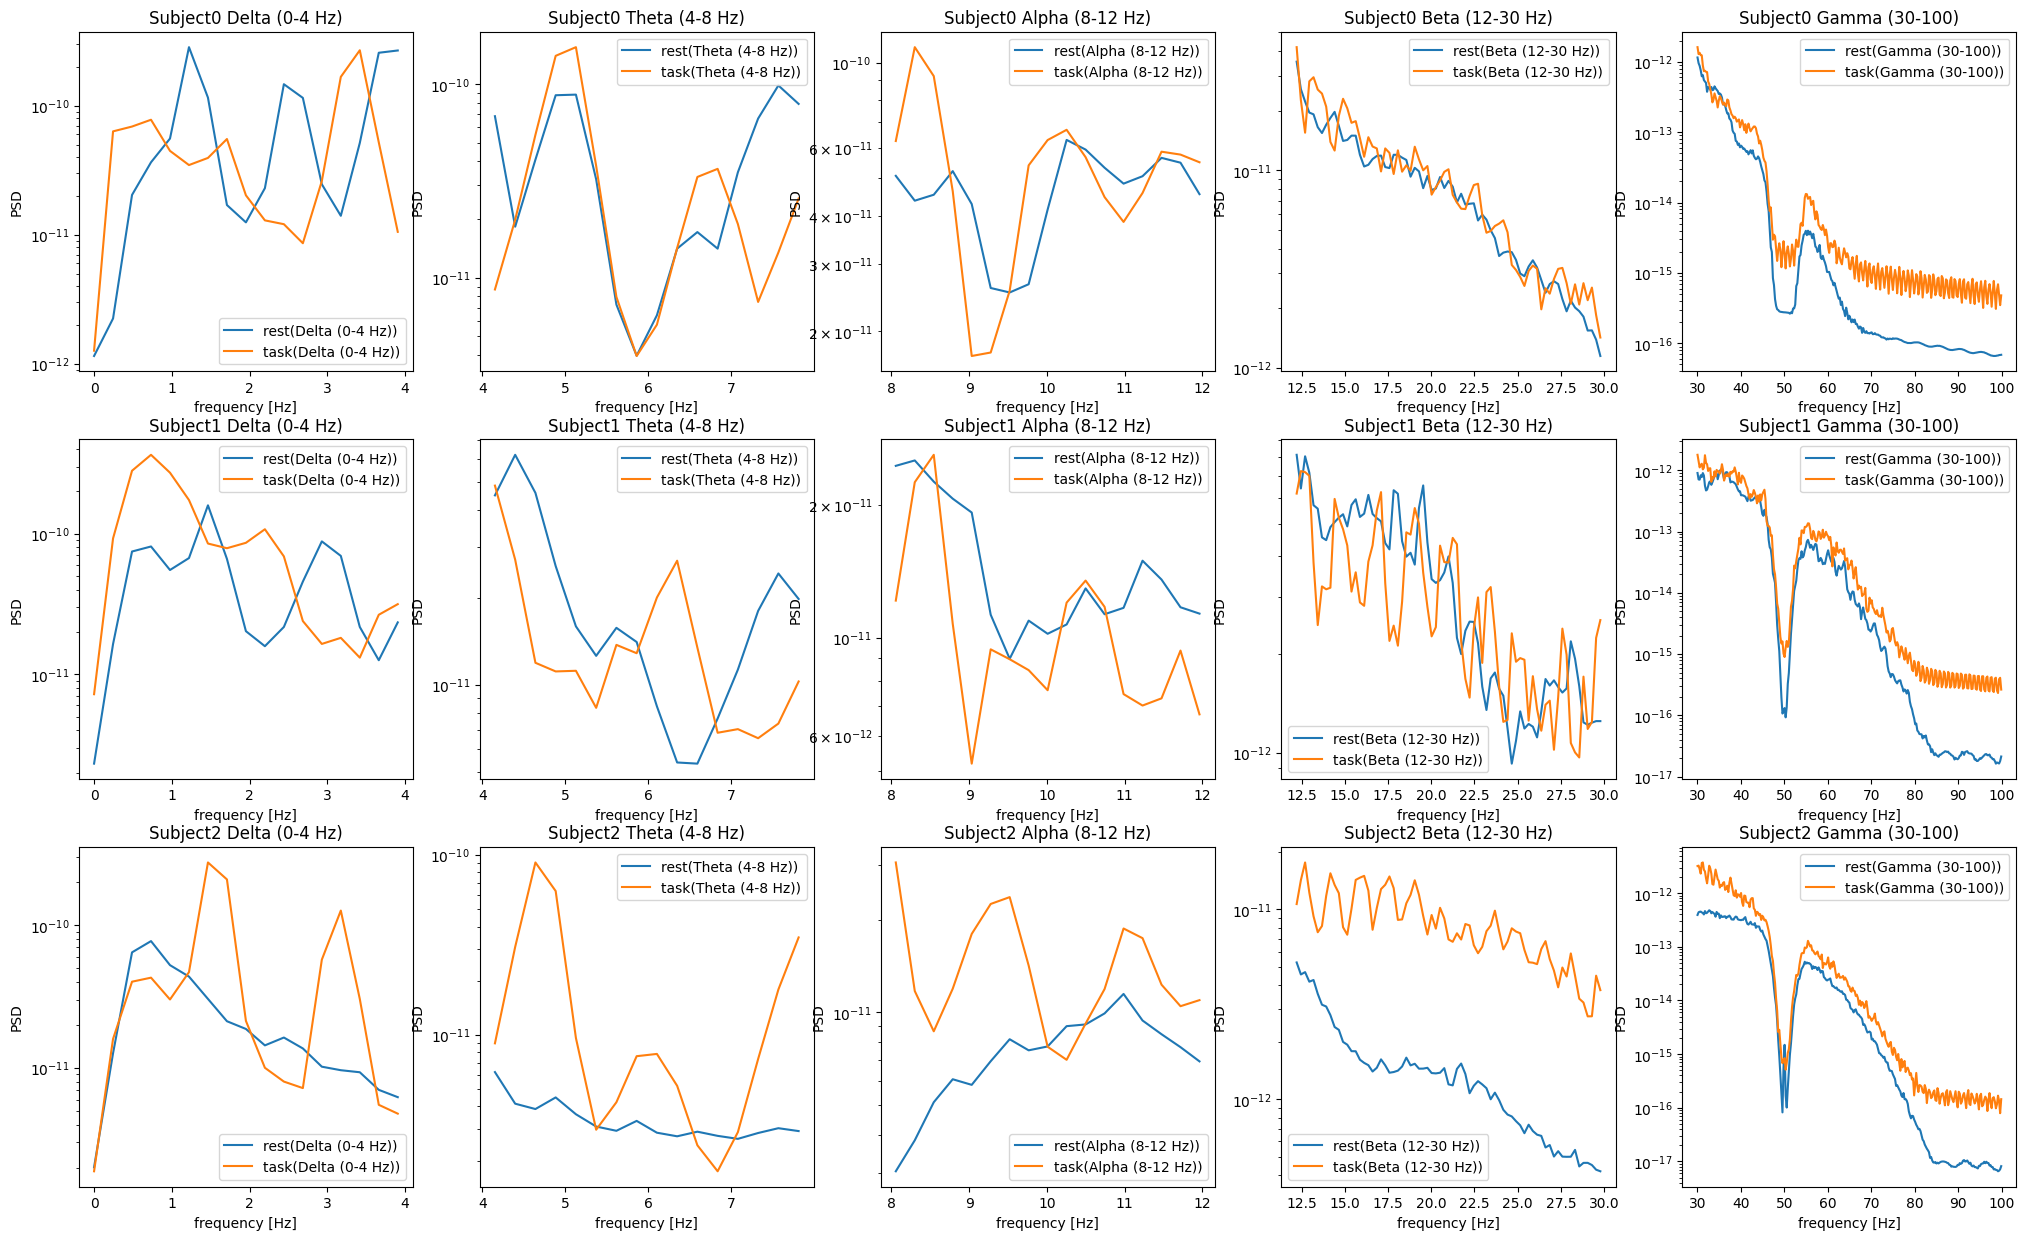

In [ ]:
subject_id=0
fig,axs= plt.subplots(3,5)
fig.set_size_inches(25,15)
for x in range(0,3):
  eeg_rest = load_eeg_data(rest_subjects[subject_id])
  eeg_task = load_eeg_data(task_subjects[subject_id])
  psd_rest = calculate_psd(eeg_rest, bands=bands)
  psd_task = calculate_psd(eeg_task, bands=bands)

  for y in range(len(psd_rest)):
    band=list(psd_rest.keys())[y]
    axs[x,y].semilogy(psd_rest[band][1], psd_rest[band][0], label=f'rest({band})')
    axs[x,y].semilogy(psd_task[band][1], psd_task[band][0], label=f'task({band})')
    axs[x,y].set_xlabel('frequency [Hz]')
    axs[x,y].set_ylabel('PSD')
    axs[x,y].set_title(f"Subject{subject_id} {band}")
    axs[x,y].legend()
  subject_id+=1
plt.show()


#Binary Classification

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, AveragePooling2D, SeparableConv2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.constraints import max_norm

In [7]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape, Permute, BatchNormalization, Activation, Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model


In [8]:
def EEGNet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, Samples, 1))
    block1 = Conv2D(F1, (1, kernLength), padding='same', input_shape=(Chans, Samples, 1), use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    flatten = Flatten(name='flatten')(block2)

    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [9]:
def TSCeption(nb_classes, Chans=64, Samples=128, dropoutRate=0.5):
    input1 = Input(shape=(Chans, Samples, 1))

    # Temporal Convolutional Layer
    temporal_layer = Conv2D(filters=32, kernel_size=(1, 3), padding='same', activation='relu')(input1)
    temporal_layer = Conv2D(filters=32, kernel_size=(1, 3), padding='same', activation='relu')(temporal_layer)

    # Reshape and Permute for Spatial Convolutional Layer
    reshaped_layer = Reshape((Chans, Samples, 32))(temporal_layer)
    permuted_layer = Permute((2, 1, 3))(reshaped_layer)

    # Spatial Convolutional Layer
    spatial_layer = Conv2D(filters=32, kernel_size=(3, 1), padding='same', activation='relu')(permuted_layer)

    # Global Average Pooling
    gap_layer = GlobalAveragePooling2D()(spatial_layer)

    # Dense and Output Layer
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.5))(gap_layer)
    softmax = Activation('softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [10]:
def make_epochs(file, duration=3, overlap=1):
  eeg= load_eeg_data(file)
  return mne.make_fixed_length_epochs(eeg, duration=duration, overlap=overlap).get_data()

In [11]:
data= make_epochs(rest_subjects[0])
data.shape

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1500 original time points ...
0 bad epochs dropped


(90, 21, 1500)

In [12]:
%%capture
data_rest=[]
data_task=[]
for x in range(1,len(rest_subjects)):
  data= make_epochs(rest_subjects[x])
  for y in data:
    data_rest.append(y)

for x in range(1,len(task_subjects)):
  data= make_epochs(task_subjects[x])
  for y in data:
    data_task.append(y)

In [ ]:
data_rest[0].shape

(21, 1500)

In [ ]:
X, y = np.array(data_rest+data_task), np.array([0]*len(data_rest)+[1]*len(data_task))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=456, stratify=y)

In [ ]:
X.shape

(4146, 21, 1500)

In [ ]:
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Train set distribution:")
for i, count in enumerate(counts):
    print(f"Class {unique[i]}: {count} samples")
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print("\nTest set distribution:")
for i, count in enumerate(counts):
    print(f"Class {unique[i]}: {count} samples")


Train set distribution:
Class 0: 2476 samples
Class 1: 840 samples

Test set distribution:
Class 0: 620 samples
Class 1: 210 samples


In [23]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Define model parameters
Chans = X_train.shape[1]
Samples = X_train.shape[2]
nb_classes = 2

# Initialize and compile the model
eegnet_model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples)
eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
y_train.shape

(3316, 2)

In [ ]:
history = eegnet_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[earlystop])

Epoch 1/20
83/83 [==============================] - 84s 977ms/step - loss: 0.6106 - accuracy: 0.7289 - val_loss: 0.5969 - val_accuracy: 0.7244
Epoch 2/20
83/83 [==============================] - 76s 923ms/step - loss: 0.5626 - accuracy: 0.7523 - val_loss: 0.5958 - val_accuracy: 0.7244
Epoch 3/20
83/83 [==============================] - 77s 931ms/step - loss: 0.5598 - accuracy: 0.7526 - val_loss: 0.5998 - val_accuracy: 0.7244
Epoch 4/20
83/83 [==============================] - 75s 905ms/step - loss: 0.5575 - accuracy: 0.7519 - val_loss: 0.6003 - val_accuracy: 0.7244
Epoch 5/20
83/83 [==============================] - 76s 918ms/step - loss: 0.5531 - accuracy: 0.7526 - val_loss: 0.5920 - val_accuracy: 0.7244
Epoch 6/20
83/83 [==============================] - 74s 891ms/step - loss: 0.5517 - accuracy: 0.7530 - val_loss: 0.7223 - val_accuracy: 0.7244
Epoch 7/20
83/83 [==============================] - 74s 895ms/step - loss: 0.5393 - accuracy: 0.7530 - val_loss: 0.6749 - val_accuracy: 0.7244

# The metrics and confusion matrix indicate that the model is still predicting the majority class for all instances, which means it is not learning to differentiate between the classes effectively.

#Resample Data to get Better results

In [13]:
from sklearn.utils import resample

data_task = resample(data_task, replace=True, n_samples=len(data_rest), random_state=42)



In [14]:
X, y = np.array(data_rest+data_task), np.array([0]*len(data_rest)+[1]*len(data_task))

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [16]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=456, stratify=y)

In [18]:
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Train set distribution:")
for i, count in enumerate(counts):
    print(f"Class {unique[i]}: {count} samples")
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print("\nTest set distribution:")
for i, count in enumerate(counts):
    print(f"Class {unique[i]}: {count} samples")


Train set distribution:
Class 0: 2476 samples
Class 1: 2477 samples

Test set distribution:
Class 0: 620 samples
Class 1: 619 samples


In [39]:
# Define model parameters
Chans = X_train.shape[1]
Samples = X_train.shape[2]
nb_classes = 2

# Initialize and compile the model
eegnet_model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples)
eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [40]:
history = eegnet_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[earlystop])

Epoch 1/20
124/124 [==============================] - 119s 946ms/step - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5106
Epoch 2/20
124/124 [==============================] - 114s 919ms/step - loss: 0.6924 - accuracy: 0.5227 - val_loss: 0.6931 - val_accuracy: 0.5106
Epoch 3/20
124/124 [==============================] - 114s 918ms/step - loss: 0.6855 - accuracy: 0.5679 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 4/20
124/124 [==============================] - 119s 956ms/step - loss: 0.6723 - accuracy: 0.5813 - val_loss: 0.6960 - val_accuracy: 0.5106
Epoch 5/20
124/124 [==============================] - 120s 967ms/step - loss: 0.6609 - accuracy: 0.6136 - val_loss: 0.6907 - val_accuracy: 0.5136
Epoch 6/20
124/124 [==============================] - 113s 909ms/step - loss: 0.6541 - accuracy: 0.6237 - val_loss: 1.1259 - val_accuracy: 0.5106
Epoch 7/20
124/124 [==============================] - 114s 917ms/step - loss: 0.6465 - accuracy: 0.6270 - val_loss: 2.3371 -

In [44]:
import sklearn.metrics as metrics
# Predict on the test set
y_pred = eegnet_model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = metrics.accuracy_score(y_true_classes, y_pred_classes)
precision = metrics.precision_score(y_true_classes, y_pred_classes)
recall = metrics.recall_score(y_true_classes, y_pred_classes)
f1_score = metrics.f1_score(y_true_classes, y_pred_classes)
confusion_matrix = metrics.confusion_matrix(y_true_classes, y_pred_classes)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Confusion Matrix:\n{confusion_matrix}")


39/39 [==============================] - 8s 200ms/step
Accuracy: 0.5004035512510089
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
Confusion Matrix:
[[  1 619]
 [  0 619]]


#Tsception Model

In [20]:
nb_classes = y_train.shape[1]
Chans = X_train.shape[1]
Samples = X_train.shape[2]
tsception_model = TSCeption(nb_classes=nb_classes, Chans=Chans, Samples=Samples)
tsception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
tsception_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[earlystop])

Epoch 1/10
124/124 [==============================] - 291s 2s/step - loss: 0.6933 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4894
Epoch 2/10
124/124 [==============================] - 288s 2s/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.4894
Epoch 3/10
124/124 [==============================] - 291s 2s/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4894
Epoch 4/10
124/124 [==============================] - 277s 2s/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4894
Epoch 5/10
124/124 [==============================] - 288s 2s/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6933 - val_accuracy: 0.4894


In [25]:
import sklearn.metrics as metrics
# Predict on the test set
y_pred = tsception_model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = metrics.accuracy_score(y_true_classes, y_pred_classes)
precision = metrics.precision_score(y_true_classes, y_pred_classes)
recall = metrics.recall_score(y_true_classes, y_pred_classes)
f1_score = metrics.f1_score(y_true_classes, y_pred_classes)
confusion_matrix = metrics.confusion_matrix(y_true_classes, y_pred_classes)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Confusion Matrix:\n{confusion_matrix}")

39/39 [==============================] - 29s 729ms/step
Accuracy: 0.4995964487489911
Precision: 0.4995964487489911
Recall: 1.0
F1 Score: 0.666307857911733
Confusion Matrix:
[[  0 620]
 [  0 619]]
